# FX Candle Analysis

## Analyiss for historical chart data

### Data

dataset: [FX-1-Minute-Data](https://github.com/philipperemy/FX-1-Minute-Data)  
trading pair: gbpusd
datetime: EST (JST -13)

### Analysis

When volatility was high in general?

- in the evening? which timezone?
- Thrusday or Friday?
- just after HH:00 or before 5 mins of them?

## Implementation

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
from datetime import timedelta

In [133]:
# CONFIG

GBPUSD_INPUT_PATH = "input/gbpusd/*/*.csv"
GBPUSD_DATA_DIR = "data/gbpusd"

def get_gbpusd_base_data_path(timezone="est"):
    return f"{GBPUSD_DATA_DIR}/{timezone}_base.pkl"

In [231]:
# General

## Time
def convert_est_to_jst(t):
    TIMEZONE_DIFF_EST_TO_JST = 13
    return t + timedelta(hours=TIMEZONE_DIFF_EST_TO_JST)


## Files
def mkdir_recursively_from_filepath(path):
    base_dir = '/'.join(path.split('/')[:-1])
    os.makedirs(base_dir, exist_ok=True)

def save_as_pkl(df, path):
    mkdir_recursively_from_filepath(path)
    df.to_pickle(path)
    print(f"\nSuccessfully saved the data as pickle, path: {path}")
    
## Pandas
def show(df):
    print(df.info())
    print(df.head())

In [242]:
def read_csv_and_format(path):
    df = pd.read_csv(path, sep=";", names=["row_time", "open", "high", "low", "close", "volume"])
    df["datetime"] = pd.to_datetime(df["row_time"], format='%Y%m%d %H%M%S')
    df.drop(["row_time"], axis=1, inplace=True)
    return df
    
def save_data_with_timezone(df_raw):
    for timezone in ["est", "jst"]:
        df = df_raw.copy()
        if timezone == "est":
            df[timezone] = df["datetime"]
        if timezone == "jst":
            df[timezone] = df["datetime"].apply(convert_est_to_jst)
    
        df.set_index(timezone, inplace=True)
        df.drop(["datetime"], axis=1, inplace=True)
        
        show(df)
        save_as_pkl(df, get_gbpusd_base_data_path(timezone))

def compact_data():
    gbpusd_input_paths = sorted(glob(GBPUSD_INPUT_PATH))
    print(f"gbpusd_input_paths num: {len(gbpusd_input_paths)}")
    total_files_num = len(gbpusd_input_paths)

    df_all = pd.DataFrame()
    for i, path in enumerate(gbpusd_input_paths, 1):
        print("============")
        print(f"fetching #{i}/{total_files_num} csv file named {path}")
        
        df = read_csv_and_format(path)
        df_all = pd.concat([df_all, df])
    
    save_data_with_timezone(df_all)

    
def read_base_data(timezone="est", show_info=False):
    path = get_gbpusd_base_data_path(timezone)
    df = pd.read_pickle(path)
    
    if show_info:
        print(df.info())
        print(df.head())
    return df

In [233]:
compact_data()

gbpusd_input_paths num: 29
fetching #1/29 csv file named input/gbpusd/DAT_ASCII_GBPUSD_M1_2000/DAT_ASCII_GBPUSD_M1_2000.csv
fetching #2/29 csv file named input/gbpusd/DAT_ASCII_GBPUSD_M1_2001/DAT_ASCII_GBPUSD_M1_2001.csv
fetching #3/29 csv file named input/gbpusd/DAT_ASCII_GBPUSD_M1_2002/DAT_ASCII_GBPUSD_M1_2002.csv
fetching #4/29 csv file named input/gbpusd/DAT_ASCII_GBPUSD_M1_2003/DAT_ASCII_GBPUSD_M1_2003.csv
fetching #5/29 csv file named input/gbpusd/DAT_ASCII_GBPUSD_M1_2004/DAT_ASCII_GBPUSD_M1_2004.csv
fetching #6/29 csv file named input/gbpusd/DAT_ASCII_GBPUSD_M1_2005/DAT_ASCII_GBPUSD_M1_2005.csv
fetching #7/29 csv file named input/gbpusd/DAT_ASCII_GBPUSD_M1_2006/DAT_ASCII_GBPUSD_M1_2006.csv
fetching #8/29 csv file named input/gbpusd/DAT_ASCII_GBPUSD_M1_2007/DAT_ASCII_GBPUSD_M1_2007.csv
fetching #9/29 csv file named input/gbpusd/DAT_ASCII_GBPUSD_M1_2008/DAT_ASCII_GBPUSD_M1_2008.csv
fetching #10/29 csv file named input/gbpusd/DAT_ASCII_GBPUSD_M1_2009/DAT_ASCII_GBPUSD_M1_2009.csv
fe

### 1 minute analysis

In [243]:
def get_volatility_df():
    df = read_base_data()
    df["volatility"] = df["high"] - df["low"]
    df = df[["volatility", "volume"]]
    return df

# weekday == 0 => Mon
def set_multi_indexes(df):
    df_yqmw = df.set_index([df.index.year, df.index.quarter, df.index.month, df.index.weekday, df.index.day])
    df_yqmw.index.names = ['year', 'quarter', 'month', 'weekday', 'day']
    df_yqmw.sort_index(inplace=True)
    return df_yqmw


df = get_volatility_df()
df = set_multi_indexes(df)

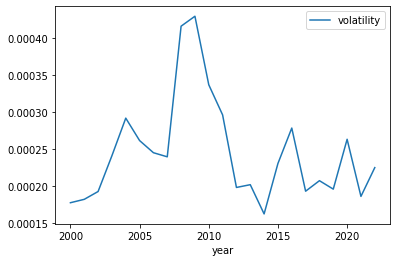

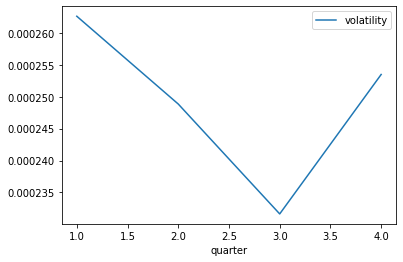

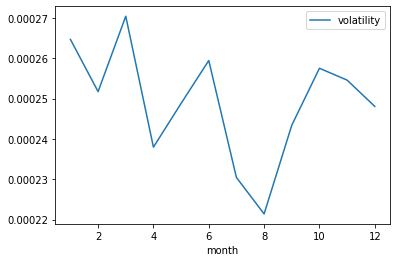

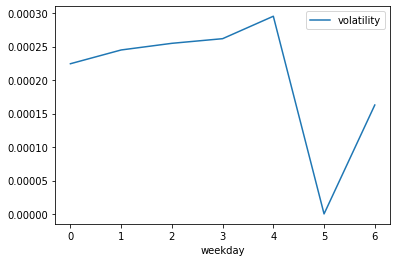

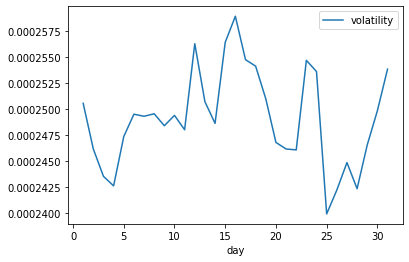

In [244]:
def plot_line(df):
    df.drop("volume", axis=1, inplace=True)
    df.plot.line()

plot_line(df.groupby(level="year").mean())
plot_line(df.groupby(level="quarter").mean())
plot_line(df.groupby(level="month").mean())
plot_line(df.groupby(level="weekday").mean())
plot_line(df.groupby(level="day").mean())

### 5 minutes analysis

In [245]:
def convert_to_5min_step(t):
    minute = t.minute
    diff = minute % 5
    return t - timedelta(minutes=diff)

def calc_5min_high_low(df):
    df["tmp"] = df.index
    df["5min_step"] = df["tmp"].apply(convert_to_5min_step)
    
    df = df.groupby("5min_step").agg(
        max_high=pd.NamedAgg(column="high", aggfunc="max"),
        min_low=pd.NamedAgg(column="low", aggfunc="min"))
    
    return df
    
def plot_5min_step_summaries(df_raw):
    df = df_raw.copy()
    
    df["volatility"] = df["max_high"] - df["min_low"]
    df.drop(["max_high", "min_low"], axis=1, inplace=True)
    
    df.set_index([df.index.day, df.index.weekday, df.index.hour, df.index.minute], inplace=True)
    df.index.names = ["day", "weekday", "hour", "minute"]
    df.sort_index(inplace=True)
    
    df.groupby(level="day").mean().plot.line()
    df.groupby(level="weekday").mean().plot.line()
    df.groupby(level="hour").mean().plot.line()
    df.groupby(level="minute").mean().plot.line()

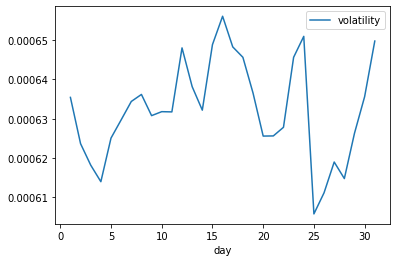

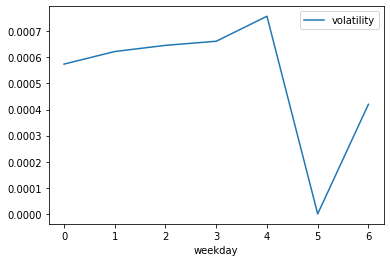

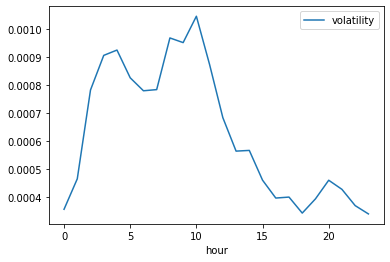

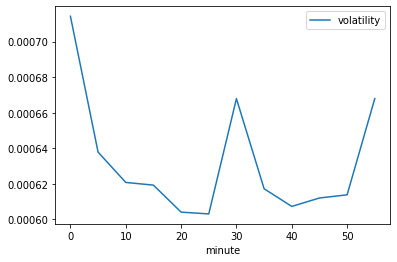

In [246]:
est = read_base_data()
est = calc_5min_high_low(est)
plot_5min_step_summaries(est)

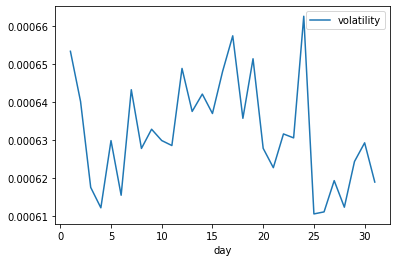

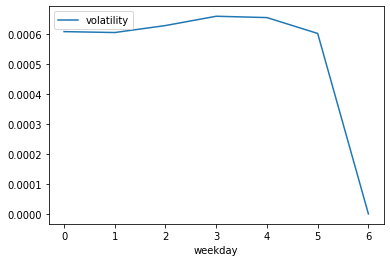

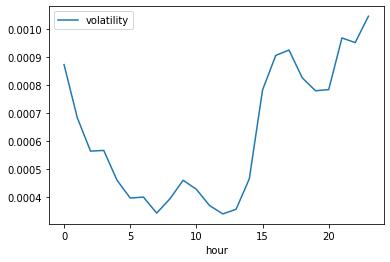

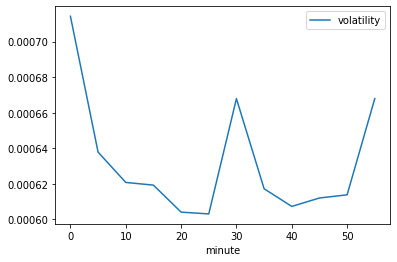

In [247]:
jst = read_base_data(timezone="jst")
jst = calc_5min_high_low(jst)
plot_5min_step_summaries(jst)

## Conclusion for 5 minutes step analysis

GBP is the currency in UK. It must be normal that the volatily was at the peak in their timezone, UTC+1.  
In JST, the peak of the trading was around 15:00-25:00 (jst), especially, **16:00-18:00** and **21:00-25:00** on the hour level plot.

Minute level plot is also interesting. It seems that the volatility was at the peak around **30-35** and **55-05**. 

Therefore, to mixize the efficiency of the trading, it's good to start to trade(and notify) at the time(jst) below.

1. 16:00  
2. 16:30, 16:55  
3. 17:30, 17:55  
4. 21:00  
5. 21:30, 21:55  
6. 22:30, 22:55  
7. 23:30, 23:55  
8. 24:30, 24:55  

Total time would be 100 minutes per day